# Validation All

2024-09-23 20:10:30.887178: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-23 20:10:30.935380: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/autofs/space/bal_004/users/jd1677/singularity-images/tensorflow_2.13.0-gpu/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Issue loading cv2


********** Mom: 32  trimester:  3
age: 31


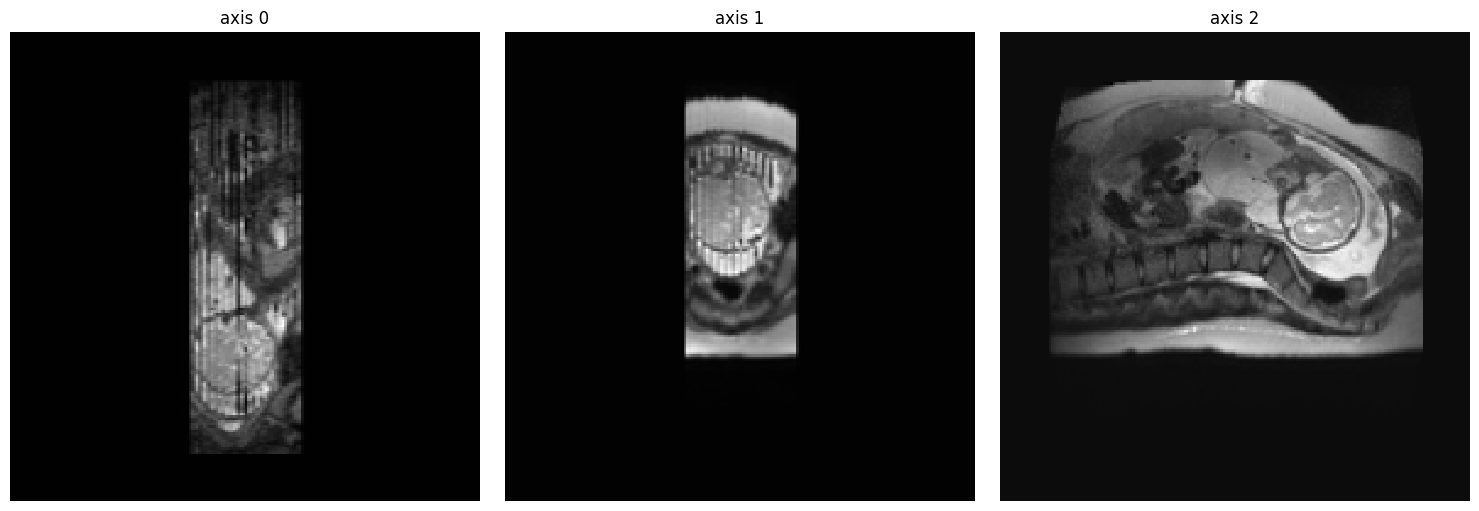

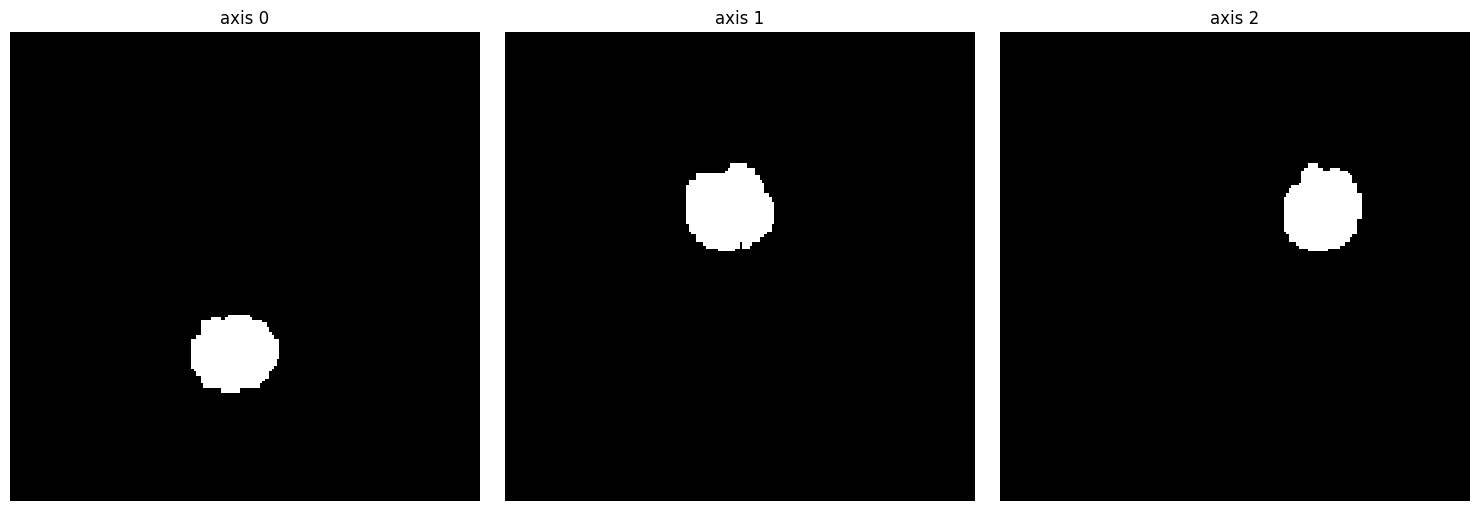

48Net model is loading


2024-09-23 20:10:46.040491: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: UNKNOWN ERROR (34)
0it [00:00, ?it/s]


48Net model is loading


  0%|          | 0/1 [00:00<?, ?it/s]

image.geom.voxsize [2.08333333 2.08333333 2.08333333]
detection True


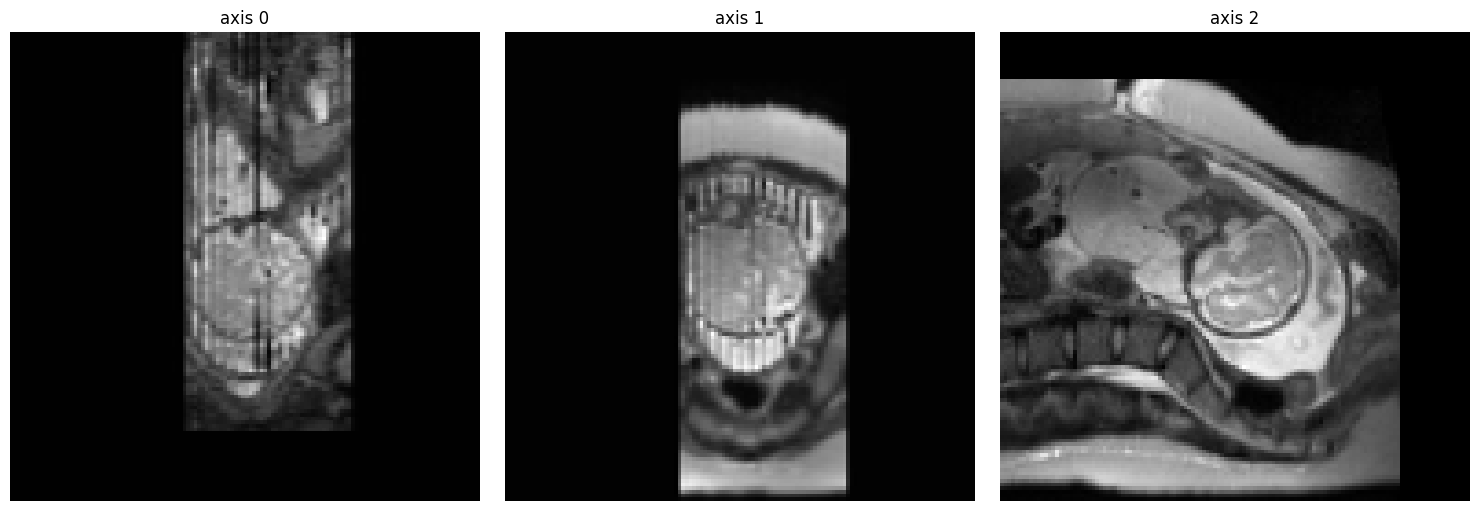

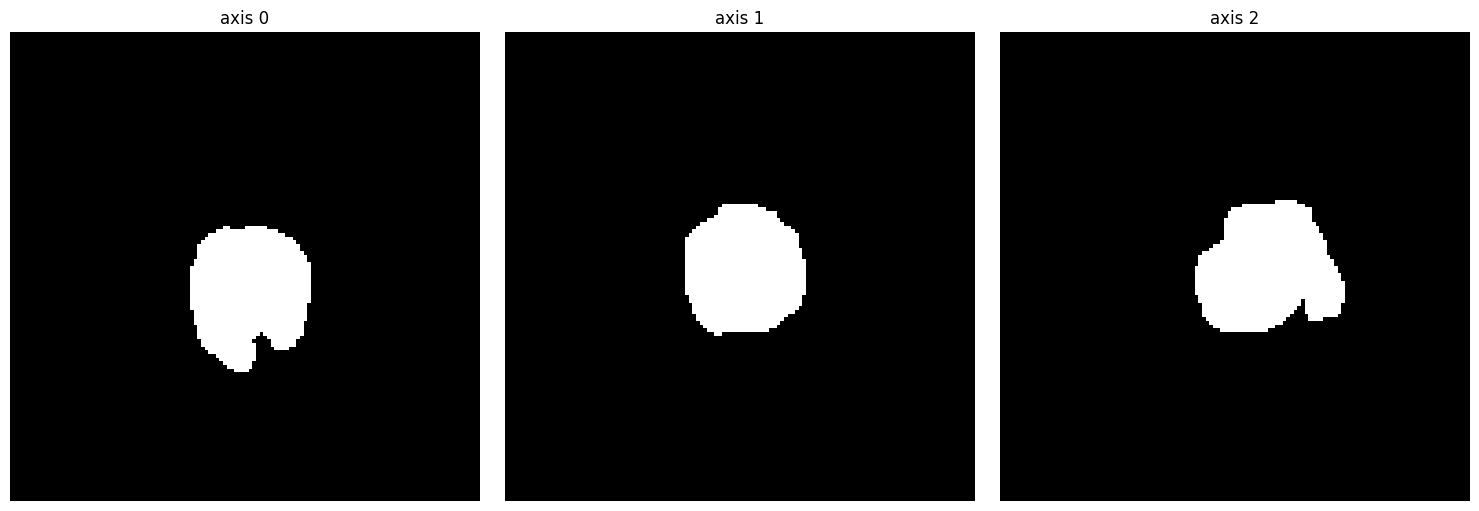

  0%|          | 0/1 [00:14<?, ?it/s]

### 48Net Hard dice:  0.8211621352785146
### distance 34 (7, 64, 26, 135, 192, 154)
len(pred_list) 1
24Net model is loading


second stage has started.. 


  0%|          | 0/2 [00:00<?, ?it/s]

min_size 5000
24 started (7, 64, 26, 135, 192, 154)
find brain 24 detection True 18


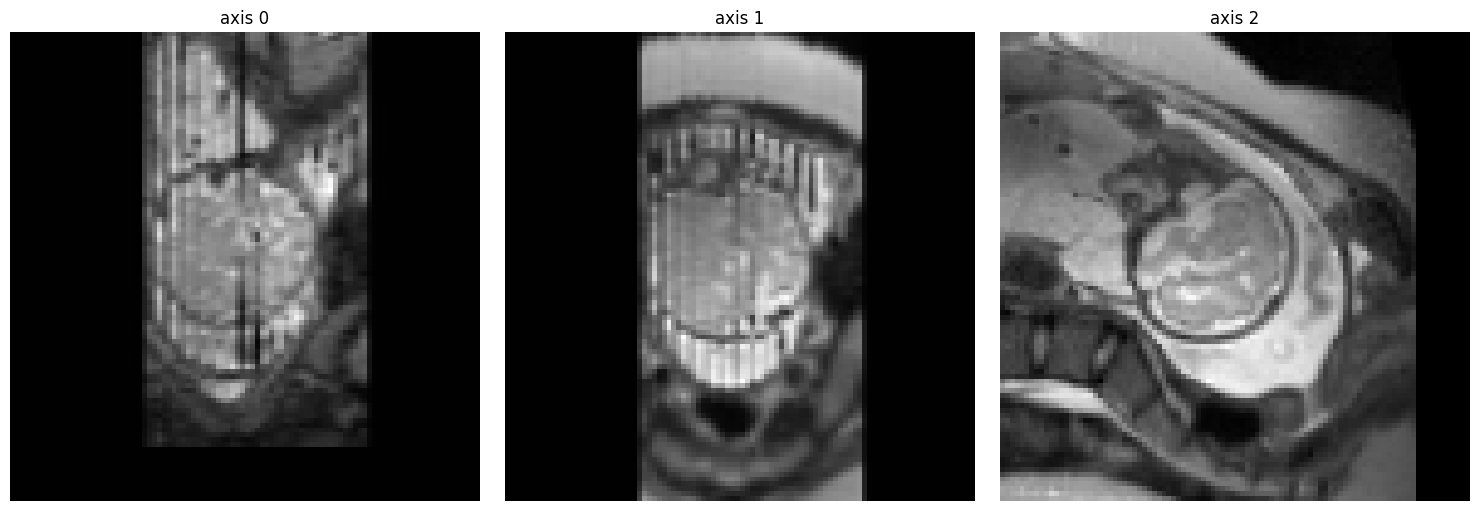

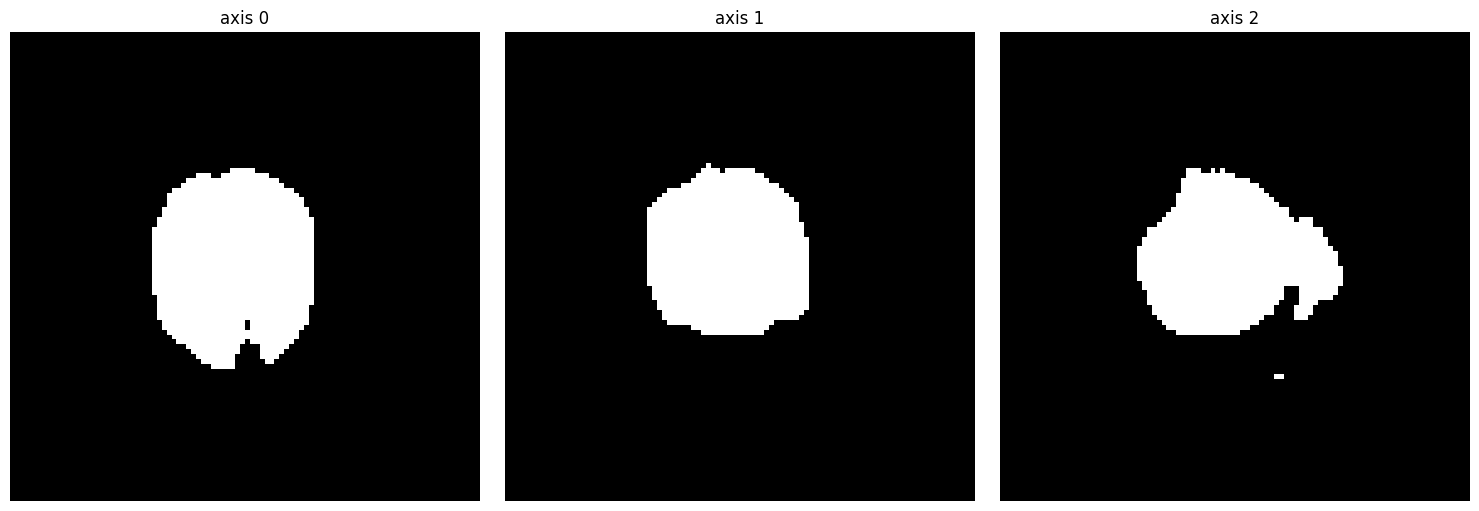

  0%|          | 0/2 [00:18<?, ?it/s]

### 24Net Hard dice:  0.5179424508387956
second stage has been found.. 
12Net model is loading


3rd stage : min size 5000


  0%|          | 0/2 [00:00<?, ?it/s]

12Net has started .. 
find brain 12 detection True


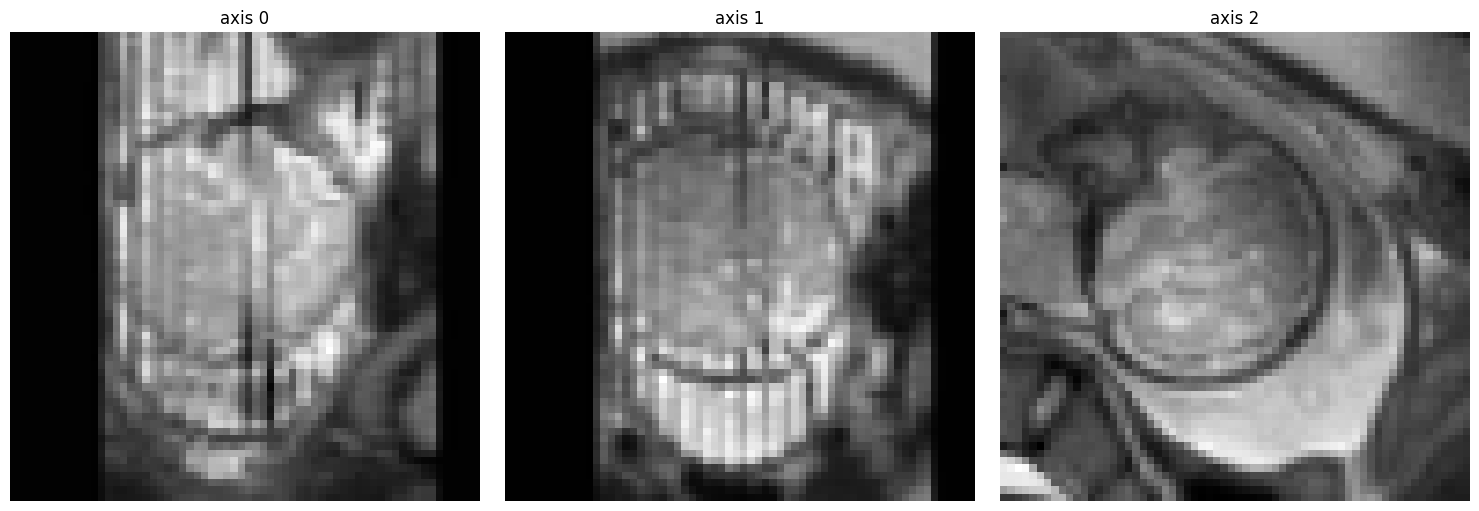

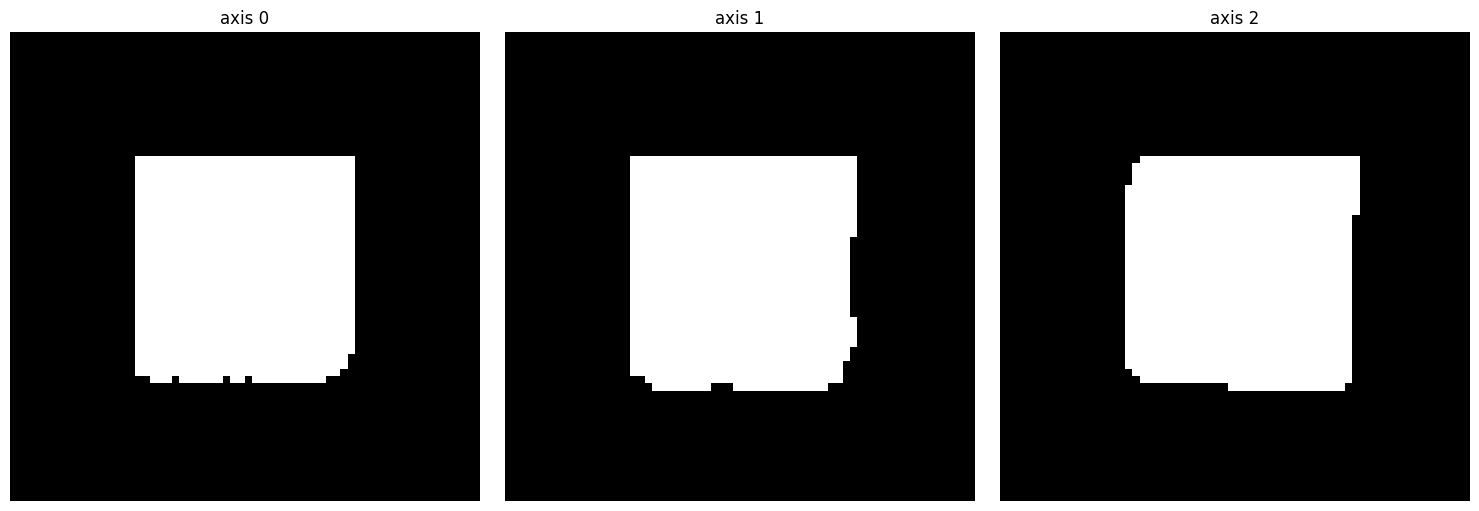

  0%|          | 0/2 [00:04<?, ?it/s]

### 12Net Hard dice:  0.7464447445777389
6Net model is loading



  0%|          | 0/2 [00:00<?, ?it/s]

6Net has started .. 
find brain 6Net detection True 2
valid_position_index_192 from 48 26 64 39 154 192 167 128 128 128


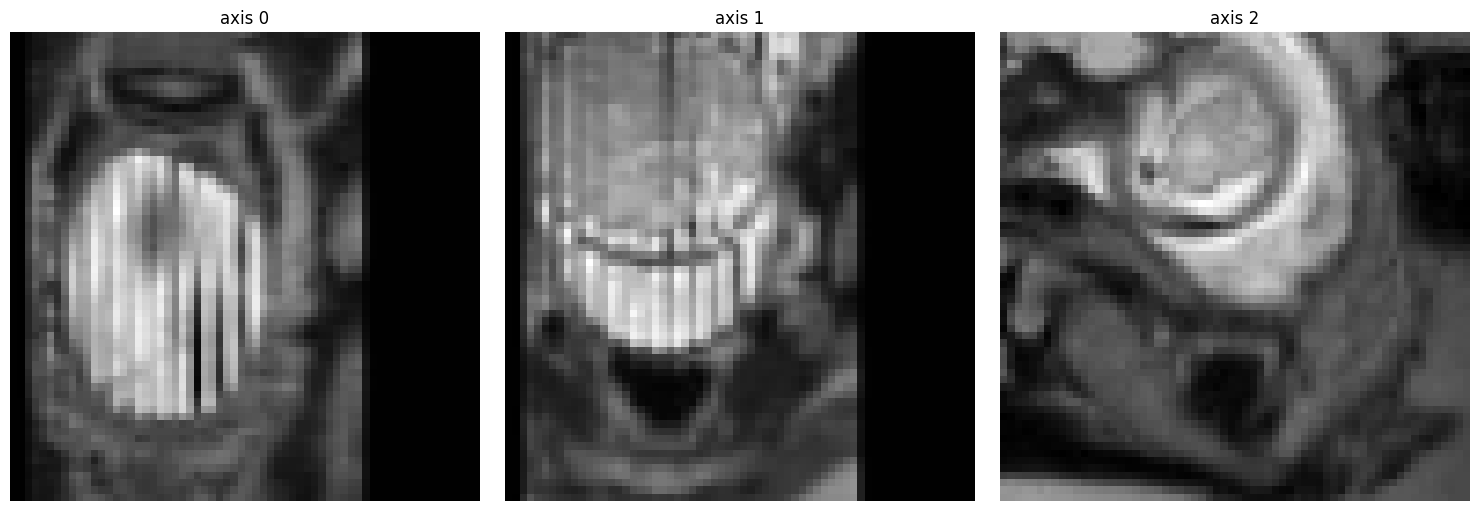

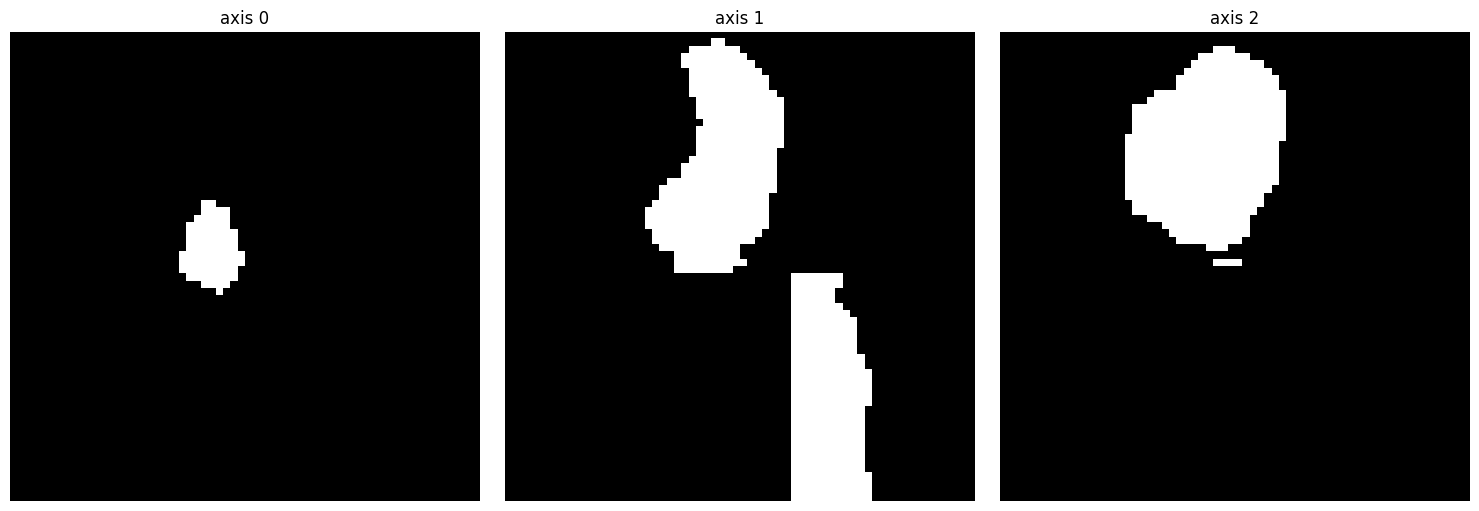

  0%|          | 0/2 [00:03<?, ?it/s]

### 6Net Hard dice:  0.33912118144774067


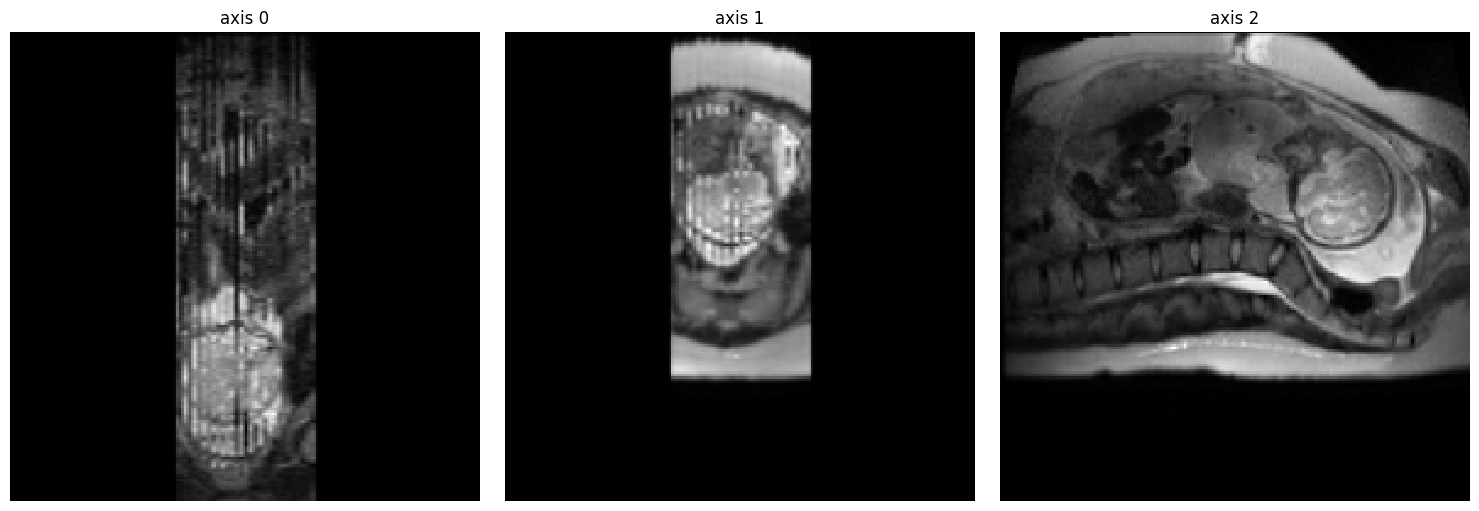

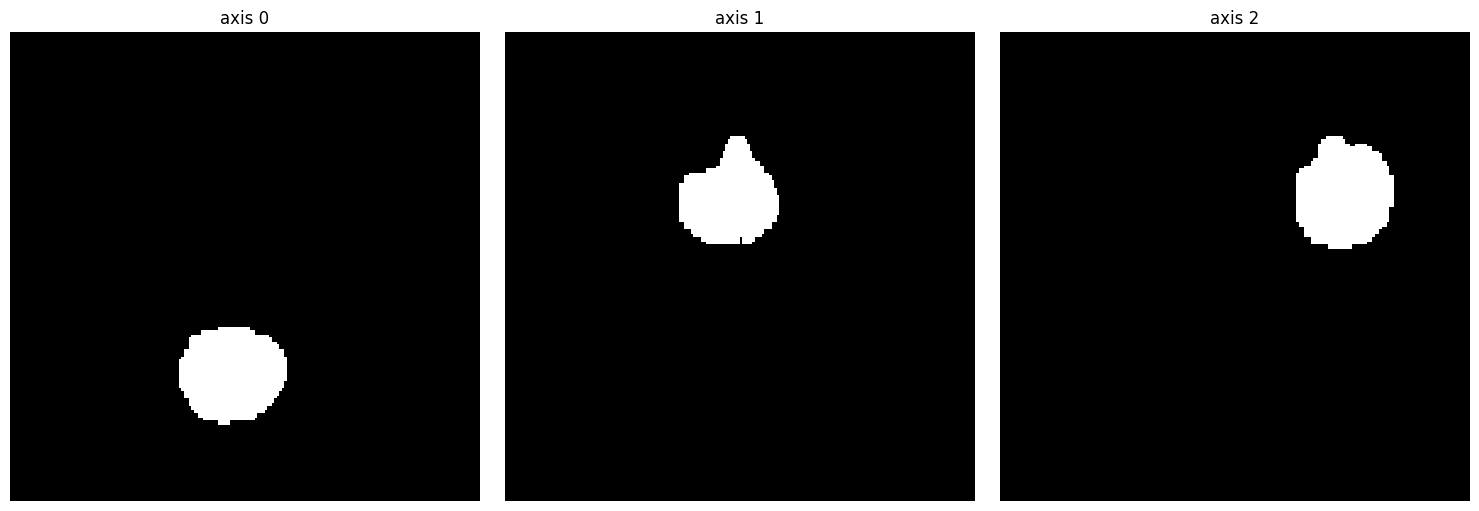

Consensus prediction .. 


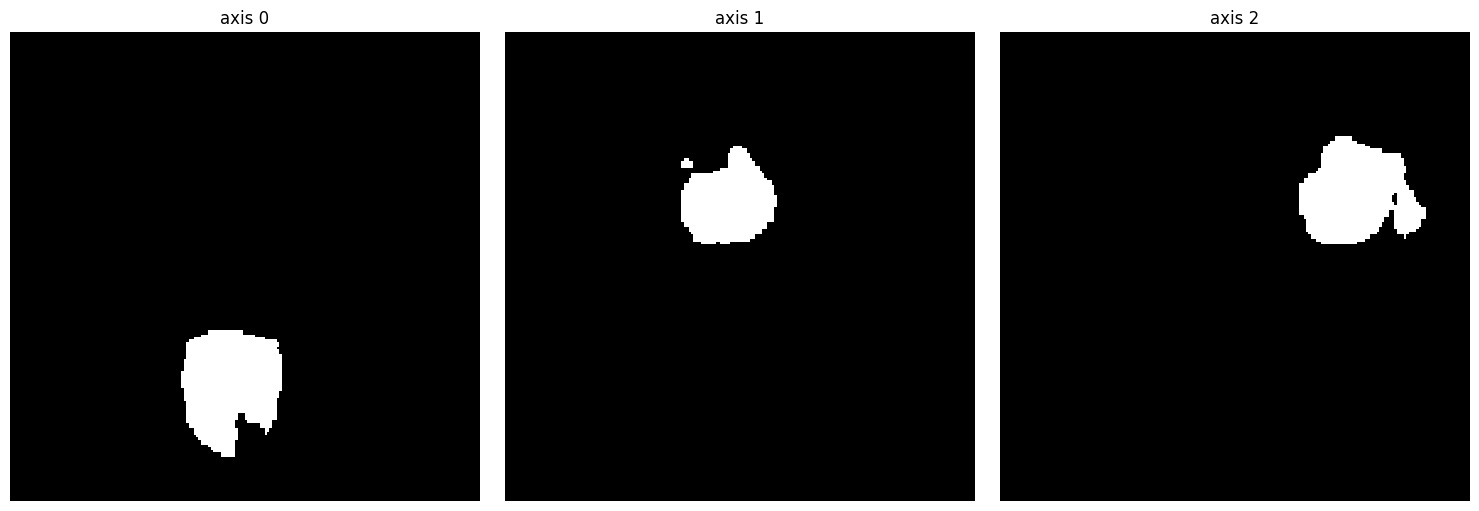

Mom: 32  ### my_hard_dice:  0.8394270152038256


In [1]:
#### from tensorflow.keras.models import load_model
import numpy as np
import tensorflow as tf
from neurite_sandbox.tf.models import labels_to_labels
from neurite_sandbox.tf.utils.augment import add_outside_shapes
from neurite.tf.utils.augment import draw_perlin_full

import tensorflow.keras.layers as KL
import voxelmorph as vxm
from utils import *
from help import *

import argparse
from tensorflow.keras.callbacks import ReduceLROnPlateau
import pathlib
import surfa as sf
import re
import json
from keras import backend as K
import param_3d
import data
import model_3d
from data_3d import *
import scipy.ndimage as ndimage

import nibabel as nib
from tqdm import tqdm
import scipy.ndimage

from scipy.ndimage import label
validation_folder_path="validation23"
validation_folder_path="test/haste_trim3"
validation_folder_path = "test/haste_trim2"
validation_folders = ["test/haste_trim3"]
# validation_folders = ["EPI_150"]
import gc

# image_index = [138,144,42,88,132,94,79,62,15,46,141,124,]
image_index= [125]

from scipy import ndimage
extent_ratio_th = 1.5
resize_factor = 2.1

import numpy as np



def calculate_containment_percentage(current_mask, previous_mask):
    # Calculate the percentage of the current mask contained within the previous mask
    current_mask_largest = find_largest_component(current_mask)
    previous_mask_largest = find_largest_component(previous_mask)
    intersection = np.logical_and(current_mask_largest, previous_mask_largest)
    containment_percentage = intersection.sum() / current_mask_largest.sum()
    return containment_percentage



def connected_components_3d(mask):
    structure = np.ones((3, 3, 3))  # 3D connectivity
    return label(mask, structure=structure)
    


def check_cube_fit(volume, cube_size=(64, 64, 64)):
    coords = np.argwhere(volume)
    bbox_shape = coords.max(axis=0) - coords.min(axis=0) + 1
    max_shape = np.max(bbox_shape)
    print("#####",bbox_shape,max_shape,cube_size[0])
    return max_shape < cube_size[0]

def adjust_weights(pred_mask):
    flat_mask = pred_mask.flatten()
    unique_vals = np.unique(flat_mask[flat_mask > 0])
    if len(unique_vals) <= 1:
        print("*** only one unique ***")
        return pred_mask

    cutoff = len(unique_vals) * 1 // 5  # 40% cutoff
    least_40_percent = unique_vals[:cutoff]
    max_weight = np.max(flat_mask)
    return np.where(np.isin(flat_mask, least_40_percent) | (flat_mask == 0), flat_mask, max_weight).reshape(pred_mask.shape)

def combine_masks_weighted_voting(pred_list, first_mask_weight=1.5):
    # Assign a higher weight to the first mask
    weighted_sum = first_mask_weight * pred_list[0]
    
    # Add other masks with weight 1
    for mask in pred_list[1:]:
        weighted_sum += mask
    
    # Perform majority voting based on the weighted sum
    combined_mask = (weighted_sum > (first_mask_weight + len(pred_list) - 1) / 2).astype(int)
    
    return combined_mask
    
def process_predictions(pred_list, image, mask, param_3d, touches_edge,first_pred_192,first_pred_32_192, trimester,age,zoom_factor):
    pred_192 = combine_masks_weighted_voting(pred_list, first_mask_weight=2)
    pred_192 = zoom_and_pad_binary_mask(pred_192, 1 / zoom_factor)
    pred_192 = find_largest_component(pred_192)
    return pred_192 > 0
    summed_mask = np.sum(pred_list, axis=0)
    summed_mask = adjust_weights(summed_mask)
    largest_component = summed_mask > np.max(summed_mask)/2


    if check_cube_fit(largest_component,(param_3d.img_size_6,)*3):
        print("fits 6")
        pred_192 = process_predictions_6(pred_list, image, mask, param_3d, touches_edge,first_pred_32_192, trimester)
    if check_cube_fit(largest_component,(param_3d.img_size_12,)*3):
        print("fits 12 net")
        pred_192 = process_predictions_12(pred_list, image, mask, param_3d, touches_edge,first_pred_32_192, trimester)
    else:
        print("fits 24 net")
        pred_192 =  process_predictions_24(pred_list, image, mask, param_3d, touches_edge,first_pred_32_192, trimester)

    if np.sum(pred_192)< 10000:
        pred_192 = first_pred_32_192
    return pred_192



def process_predictions_b2(pred_list, image, mask, param_3d, touches_edge,first_pred_192,first_pred_32_192, trimester,age,zoom_factor):

    # return combine_masks_majority_voting(pred_list)
    def adjust_weights(pred_mask):
        flat_mask = pred_mask.flatten()
        unique_vals = np.unique(flat_mask[flat_mask > 0])
        if len(unique_vals) <= 1:
            print("*** only one unique ***")
            return pred_mask
    
        cutoff = len(unique_vals) * 1 // 5  # 40% cutoff
        least_40_percent = unique_vals[:cutoff]
        max_weight = np.max(flat_mask)
        return np.where(np.isin(flat_mask, least_40_percent) | (flat_mask == 0), flat_mask, max_weight).reshape(pred_mask.shape)

    image.data = zoom_and_pad_binary_mask(image.data,1/zoom_factor)
    mask.data = zoom_and_pad_binary_mask(mask.data,1/zoom_factor)

    # if age> 24:
    #     pred_192 = combine_masks_majority_voting(pred_list)
    #     pred_192 = find_largest_component(pred_192)
    #     pred_192 = zoom_and_pad_binary_mask(pred_192,1/zoom_factor)
        
    #     return pred_192 > 0
    
    first_pred_32_192 = zoom_and_pad_binary_mask(first_pred_32_192,1/zoom_factor)
    first_pred_192 = zoom_and_pad_binary_mask(first_pred_192,1/zoom_factor)
    num_components, _ = ndimage.label(first_pred_32_192)
    if np.array(num_components).size == 1 and num_components == 1:
        print("0")
        return first_pred_32_192
    print("$$$$$$ zoom factor", 1/zoom_factor)
    pred_192 = combine_masks_majority_voting(pred_list)
    pred_192 = zoom_and_pad_binary_mask(pred_192,1/zoom_factor)
    pred_list = [zoom_and_pad_binary_mask(a,1/zoom_factor) for a in pred_list]
    

    num_masks = len(pred_list)

    
    summed_mask = np.sum(pred_list, axis=0)
    summed_mask = adjust_weights(summed_mask)
    largest_component = summed_mask > np.max(summed_mask)/2

    if check_cube_fit(largest_component,(param_3d.img_size_12,)*3):
        print("fits 12")
        pred_192 = process_predictions_b2_12(pred_list, image, mask, param_3d, touches_edge,first_pred_32_192, trimester)
    else:
        print("fits 24")
        pred_192 =  process_predictions_b2_24(pred_list, image, mask, param_3d, touches_edge,first_pred_32_192, trimester)
        if trimester == 3:
            return pred_192
        
    a = find_largest_component(pred_192)>0
    if np.sum(a) <5000:
        print("2/np.sum(pred_192)<20000")
        pred_192 = find_largest_component(first_pred_32_192)
    a = find_largest_component(pred_192)>0
    if np.sum(a)<5000:
        print("1")
        pred_192 = find_largest_component(first_pred_32_192)
    a = find_largest_component(pred_192)>0
    if np.sum(a)<5000:
        print("2")
        pred_192 = find_largest_component(first_pred_192)
        
    pred_192 = pred_192.astype(np.uint8)
    first_pred_32_192 = first_pred_32_192.astype(np.uint8)
    
    if np.sum(pred_192 & first_pred_32_192) == 0:
        print("3")
        pred_192 = first_pred_32_192
        
    largest_component = find_largest_component(first_pred_32_192)
    if np.sum(pred_192) > np.sum(largest_component):
        print("4")
        pred_192 =  largest_component
        
    if np.sum(pred_192)<5000:
        print("5")
        return first_pred_32_192  
    labeled_components, num_components = label(first_pred_32_192) 
    best_dice = 0
    best_component = None
    
    # Loop through each component and calculate its Dice coefficient with pred_192
    for component_id in range(1, num_components + 1):
        # Create a binary mask for the current component
        component_mask = (labeled_components == component_id)
        
        # Calculate the Dice coefficient for this component with pred_192
        dice_score = dice_coefficient(component_mask, pred_192)
        
        # Check if this component has the highest Dice score so far
        if dice_score > best_dice:
            best_dice = dice_score
            best_component = component_mask
    if dice_coefficient(component_mask,first_pred_192)==0:
        pred_192 = (first_pred_192  + first_pred_32_192)>1
    else:
    # else:
        pred_192 = best_component

    return pred_192

def process_predictions_b2_24(pred_list, image, mask, param_3d, touches_edge,first_pred_32_192, trimester):
    positions = generate_position_map((param_3d.img_size_24,)*3, param_3d.img_size_6, 16)

    num_masks = len(pred_list)
    
    summed_mask = np.sum(pred_list, axis=0)
    summed_mask = adjust_weights(summed_mask)


    largest_component = summed_mask > np.max(summed_mask)-1#find_largest_component(summed_mask)
    x1, y1, z1, x2, y2, z2 = find_bounding_box(largest_component,cube_size=param_3d.img_size_24)
    cube_24 = extract_cube(image, x1, y1, z1, x2, y2, z2, cube_size=param_3d.img_size_24)
    pred_24 = extract_cube(largest_component, x1, y1, z1, x2, y2, z2, cube_size=param_3d.img_size_24)
    mask_24 = extract_cube(mask, x1, y1, z1, x2, y2, z2, cube_size=param_3d.img_size_24)

    # valid_position_index_48 = calibrate_positions(x1, y1, z1, x2, y2, z2, param_3d.img_size_24, param_3d.img_size_48) 
    
    combined_model = get_model(models[2],trimester)
    list_pred_192 = []
    min_size = 5000
    pred_192 = np.zeros((192,)*3)
    prediction_one_hot = combined_model.predict(cube_24[None,...,None], verbose=0)
    prediction = np.argmax(prediction_one_hot,axis=-1)
    prediction = prediction[0]
    prediction[prediction != 0] = 1
    pred_192[x1:x2, y1:y2, z1:z2] = prediction
    



    x1, y1, z1, x2, y2, z2 = find_bounding_box(largest_component,cube_size=param_3d.img_size_48)
    cube_48 = extract_cube(image, x1, y1, z1, x2, y2, z2, cube_size=param_3d.img_size_48)
    pred_48 = extract_cube(largest_component, x1, y1, z1, x2, y2, z2, cube_size=param_3d.img_size_48)
    mask_48 = extract_cube(mask, x1, y1, z1, x2, y2, z2, cube_size=param_3d.img_size_48)
    valid_position_index_192 = x1, y1, z1, x2, y2, z2 

    print("x1, y1, z1, x2, y2, z2",valid_position_index_48)
    


    if trimester ==2:
        #  # Third stage
        detection, pred_12, valid_position_index_24, cube_12, mask_12, third_pred_192 = third_stage_prediction(img, mask, pred_24, cube_24, mask_24, pred_48, cube_48, mask_48, valid_position_index_48, valid_position_index_192,0, positions_12,trimester)
        third_pred_192 = zoom_and_pad_binary_mask(third_pred_192,1/zoom_factor)
        pred_list.append(third_pred_192)
        
        #Fourth stage
        # detection, pred_6, valid_position_index_12, cube_6, fourth_pred_192 = fourth_stage_prediction(img, mask, pred_12, cube_12, mask_12, cube_24, mask_24, cube_48, mask_48, valid_position_index_24, valid_position_index_48, valid_position_index_192, 0, positions_6,trimester)
        # fourth_pred_192 = zoom_and_pad_binary_mask(fourth_pred_192,1/zoom_factor)
        # pred_list.append(fourth_pred_192)
    # pred_192 = fourth_pred_192 

    # if np.sum(pred_192)<5000:
    pred_192 = combine_masks_majority_voting(pred_list)
    
    ms = np.mean(np.column_stack(np.nonzero(pred_24)), axis=0).astype(int)
    ne.plot.volume3D(cube_24, slice_nos=ms)
    ne.plot.volume3D(pred_24, slice_nos=ms)
    return pred_192
    
def process_predictions_b2_12(pred_list, image, mask, param_3d, touches_edge,first_pred_32_192, trimester):
    positions = generate_position_map((param_3d.img_size_12,)*3, param_3d.img_size_6, 8)
    pred_192 = np.zeros((192,)*3)
    num_masks = len(pred_list)
    
    
    summed_mask = np.sum(pred_list, axis=0)
    summed_mask = adjust_weights(summed_mask)


    largest_component = summed_mask > np.max(summed_mask)-1#find_largest_component(summed_mask)
    
    x1, y1, z1, x2, y2, z2 = find_bounding_box(largest_component,cube_size=param_3d.img_size_12)
    cube_24 = extract_cube(image, x1, y1, z1, x2, y2, z2, cube_size=param_3d.img_size_12)
    pred_24 = extract_cube(largest_component, x1, y1, z1, x2, y2, z2, cube_size=param_3d.img_size_12)
    mask_24 = extract_cube(mask, x1, y1, z1, x2, y2, z2, cube_size=param_3d.img_size_12)
    valid_position_index_192 = x1, y1, z1, x2, y2, z2 

    combined_model = get_model(models[1],trimester)
    list_pred_192 = []
    min_size = 1000
    prediction_one_hot = combined_model.predict(cube_24[None,...,None], verbose=0)
    prediction = np.argmax(prediction_one_hot,axis=-1)
    prediction = prediction[0]
    prediction[prediction != 0] = 1
    pred_192[x1:x2, y1:y2, z1:z2] = prediction
        
    ne.plot.volume3D(pred_192)

    
    ms = np.mean(np.column_stack(np.nonzero(pred_24)), axis=0).astype(int)
    ne.plot.volume3D(cube_24, slice_nos=ms)
    ne.plot.volume3D(pred_24, slice_nos=ms)
    return pred_192
    
def process_predictions_b2_6(pred_list, image, mask, param_3d, touches_edge,first_pred_32_192, trimester):
    pred_192 = np.zeros((192,)*3)
    num_masks = len(pred_list)
    
    
    summed_mask = np.sum(pred_list, axis=0)
    summed_mask = adjust_weights(summed_mask)


    largest_component = summed_mask > np.max(summed_mask)-1#find_largest_component(summed_mask)
    
    x1, y1, z1, x2, y2, z2 = find_bounding_box(largest_component,cube_size=param_3d.img_size_6)
    cube_24 = extract_cube(image, x1, y1, z1, x2, y2, z2, cube_size=param_3d.img_size_6)
    pred_24 = extract_cube(largest_component, x1, y1, z1, x2, y2, z2, cube_size=param_3d.img_size_6)
    mask_24 = extract_cube(mask, x1, y1, z1, x2, y2, z2, cube_size=param_3d.img_size_6)
    valid_position_index_192 = x1, y1, z1, x2, y2, z2 

    combined_model = get_model(models[0],trimester)
    list_pred_192 = []
    min_size = 1000
    prediction_one_hot = combined_model.predict(cube_24[None,...,None], verbose=0)
    prediction = np.argmax(prediction_one_hot,axis=-1)
    prediction = prediction[0]
    prediction[prediction != 0] = 1
    pred_192[x1:x2, y1:y2, z1:z2] = prediction
        
    ne.plot.volume3D(pred_192)

    
    ms = np.mean(np.column_stack(np.nonzero(pred_24)), axis=0).astype(int)
    ne.plot.volume3D(cube_24, slice_nos=ms)
    ne.plot.volume3D(pred_24, slice_nos=ms)
    return pred_192


def process_predictions_24(pred_list, image, mask, param_3d, touches_edge,first_pred_32_192, trimester):
    positions = generate_position_map((param_3d.img_size_24,)*3, param_3d.img_size_6, 16)

    num_masks = len(pred_list)
    
    # Apply binary opening and closing to each mask to clean up noise
    # pred_list = [
    #     ndimage.binary_opening(ndimage.binary_closing(a, np.ones((2, 2, 2))), np.ones((2, 2, 2))).astype(np.uint8)
    #     for a in pred_list
    # ]
    summed_mask = np.sum(pred_list, axis=0)
    summed_mask = adjust_weights(summed_mask)

    largest_component = summed_mask > np.max(summed_mask)-1
    x1, y1, z1, x2, y2, z2 = find_bounding_box(largest_component,cube_size=param_3d.img_size_48)
    cube_48 = extract_cube(image, x1, y1, z1, x2, y2, z2, cube_size=param_3d.img_size_48)
    pred_48 = extract_cube(largest_component, x1, y1, z1, x2, y2, z2, cube_size=param_3d.img_size_48)
    mask_48 = extract_cube(mask, x1, y1, z1, x2, y2, z2, cube_size=param_3d.img_size_48)
    valid_position_index_192 = x1, y1, z1, x2, y2, z2 

    #find_largest_component(summed_mask)
    x1, y1, z1, x2, y2, z2 = find_bounding_box(cube_48,cube_size=param_3d.img_size_24)
    cube_24 = extract_cube(cube_48, x1, y1, z1, x2, y2, z2, cube_size=param_3d.img_size_24)
    pred_24 = extract_cube(pred_48, x1, y1, z1, x2, y2, z2, cube_size=param_3d.img_size_24)
    mask_24 = extract_cube(mask_48, x1, y1, z1, x2, y2, z2, cube_size=param_3d.img_size_24)
    
    valid_position_index_48 = calibrate_positions(x1, y1, z1, x2, y2, z2, param_3d.img_size_24, param_3d.img_size_48) 
    # x1, y1, z1, x2, y2, z2
    pred_48 = np.zeros((param_3d.img_size_48,) * 3)
    combined_model = get_model(models[2],trimester)
    list_pred_192 = []
    min_size = 5000
    pred_192 = np.zeros((192,)*3)
    prediction_one_hot = combined_model.predict(cube_24[None,...,None], verbose=0)
    prediction = np.argmax(prediction_one_hot,axis=-1)
    prediction = prediction[0]
    prediction[prediction != 0] = 1
    pred_48[x1:x2, y1:y2, z1:z2] = prediction
    x1, y1, z1, x2, y2, z2 = valid_position_index_192
    pred_192[x1:x2, y1:y2, z1:z2] = pred_48
    pred_24 = prediction
    pred_192 = pred_192
    pred_192 = ndimage.binary_opening(ndimage.binary_closing(pred_192, np.ones((2, 2, 2))), np.ones((2, 2, 2))).astype(np.uint8)
    
    
    ms = np.mean(np.column_stack(np.nonzero(pred_24)), axis=0).astype(int)
    ne.plot.volume3D(cube_24, slice_nos=ms)
    ne.plot.volume3D(pred_24, slice_nos=ms)
    print("end of pred 24")
    return pred_192
    
def process_predictions_12(pred_list, image, mask, param_3d, touches_edge,first_pred_36_192, trimester):
    positions = generate_position_map((param_3d.img_size_12,)*3, param_3d.img_size_6, 8)
    pred_192 = np.zeros((192,)*3)
    num_masks = len(pred_list)
    
    
    summed_mask = np.sum(pred_list, axis=0)
    summed_mask = adjust_weights(summed_mask)


    largest_component = summed_mask > np.max(summed_mask)-1#find_largest_component(summed_mask)

    x1, y1, z1, x2, y2, z2 = find_bounding_box(largest_component,cube_size=param_3d.img_size_48)
    cube_48 = extract_cube(image, x1, y1, z1, x2, y2, z2, cube_size=param_3d.img_size_48)
    mask_48 = extract_cube(mask, x1, y1, z1, x2, y2, z2, cube_size=param_3d.img_size_48)
    valid_position_index_192 = x1, y1, z1, x2, y2, z2 
    
    x1, y1, z1, x2, y2, z2 = find_bounding_box(cube_48,cube_size=param_3d.img_size_24)
    cube_24 = extract_cube(cube_48, x1, y1, z1, x2, y2, z2, cube_size=param_3d.img_size_24)
    mask_24 = extract_cube(mask_48, x1, y1, z1, x2, y2, z2, cube_size=param_3d.img_size_24)
    valid_position_index_48 = x1, y1, z1, x2, y2, z2 
    
    x1, y1, z1, x2, y2, z2 = find_bounding_box(cube_24,cube_size=param_3d.img_size_12)
    cube_12 = extract_cube(cube_24, x1, y1, z1, x2, y2, z2, cube_size=param_3d.img_size_12)
    mask_12 = extract_cube(mask_24, x1, y1, z1, x2, y2, z2, cube_size=param_3d.img_size_12)
    valid_position_index_24 = x1, y1, z1, x2, y2, z2 

    combined_model = get_model(models[1],trimester)
    list_pred_192 = []
    min_size = 1000
    prediction_one_hot = combined_model.predict(cube_12[None,...,None], verbose=0)
    prediction = np.argmax(prediction_one_hot,axis=-1)
    prediction = prediction[0]
    prediction[prediction != 0] = 1

    pred_24 = np.zeros_like(mask_24)
    pred_48 = np.zeros_like(mask_48)
    pred_192 = np.zeros_like(mask)
    pred_24[x1:x2, y1:y2, z1:z2] = prediction
    x1, y1, z1, x2, y2, z2 = valid_position_index_48
    pred_48[x1:x2, y1:y2, z1:z2] = pred_24
    x1, y1, z1, x2, y2, z2 = valid_position_index_192
    pred_192[x1:x2, y1:y2, z1:z2] = pred_48


    touches_edge = 1 - is_centered_3d(pred_12, margins=(1, 1, 1))
    if touches_edge:
        pred_list.append(pred_192)
        pred_192 = combine_masks_majority_voting(pred_list)
        pred_192 = pred_192

    print("touches_edge",touches_edge)

    # pred_list = []

    
    # detection, pred_6, valid_position_index_12, cube_6, fourth_pred_192 = fourth_stage_prediction(img, mask, pred_12, cube_12, mask_12, cube_24, mask_24, cube_48, mask_48, valid_position_index_24, valid_position_index_48, valid_position_index_192, mom, positions_6,trimester)
    # pred_list.append(fourth_pred_192)
    
    # pred_192 = fourth_pred_192
    
        
    ne.plot.volume3D(pred_192)

    
    ms = np.mean(np.column_stack(np.nonzero(pred_24)), axis=0).astype(int)
    ne.plot.volume3D(cube_24, slice_nos=ms)
    ne.plot.volume3D(pred_24, slice_nos=ms)
    print("end of pred 12")
    return pred_192


    
def process_predictions_6(pred_list, image, mask, param_3d, touches_edge,first_pred_32_192, trimester):
    pred_192 = np.zeros((192,)*3)
    num_masks = len(pred_list)
    
    
    summed_mask = np.sum(pred_list, axis=0)
    summed_mask = adjust_weights(summed_mask)


    largest_component = summed_mask > np.max(summed_mask)-1
    
    x1, y1, z1, x2, y2, z2 = find_bounding_box(largest_component,cube_size=param_3d.img_size_6)
    cube_24 = extract_cube(image, x1, y1, z1, x2, y2, z2, cube_size=param_3d.img_size_6)
    pred_24 = extract_cube(largest_component, x1, y1, z1, x2, y2, z2, cube_size=param_3d.img_size_6)
    mask_24 = extract_cube(mask, x1, y1, z1, x2, y2, z2, cube_size=param_3d.img_size_6)
    valid_position_index_192 = x1, y1, z1, x2, y2, z2 

    combined_model = get_model(models[0],trimester)
    list_pred_192 = []
    min_size = 1000
    prediction_one_hot = combined_model.predict(cube_24[None,...,None], verbose=0)
    prediction = np.argmax(prediction_one_hot,axis=-1)
    prediction = prediction[0]
    prediction[prediction != 0] = 1
    pred_192[x1:x2, y1:y2, z1:z2] = prediction
        
    ne.plot.volume3D(pred_192)

    
    ms = np.mean(np.column_stack(np.nonzero(pred_24)), axis=0).astype(int)
    ne.plot.volume3D(cube_24, slice_nos=ms)
    ne.plot.volume3D(pred_24, slice_nos=ms)
    return pred_192
 
def bounding_box_3d_max_extent(volume):
    # Get the indices of non-zero elements in the 3D volume
    non_zero_indices = np.argwhere(volume > 0)
    
    # If there are no non-zero elements, return 0
    if np.sum(volume)== 0:
        return 100

    # Get the minimum and maximum coordinates along each axis (x, y, z)
    x1, y1, z1 = non_zero_indices.min(axis=0)
    x2, y2, z2 = non_zero_indices.max(axis=0)
    
    # Calculate the sides of the bounding box
    side_x = x2 - x1
    side_y = y2 - y1
    side_z = z2 - z1
    
    # Find the maximum extent (maximum side length)
    max_extent = max(side_x, side_y, side_z)
    min_extent = min(side_x, side_y, side_z)
    # Return the maximum extent
    return max_extent/min_extent


epsilon =1e-7
min_max_norm = Lambda(lambda x: (x - K.min(x)) / (K.max(x) - K.min(x)+ epsilon) * (1.0) )
detection_results = []

count = 0 
positions_48 = generate_position_map((192,192,192), param_3d.img_size_48,96 )
positions_36 = generate_position_map((192,192,192), param_3d.img_size_24, 64)
positions_34 = generate_position_map((192,192,192), param_3d.img_size_12, 64)
positions_32 = generate_position_map((192,192,192), param_3d.img_size_6, 64)

positions_24 = generate_position_map((param_3d.img_size_48,)*3, param_3d.img_size_24, 32)
positions_12 = generate_position_map((param_3d.img_size_24,)*3, param_3d.img_size_12, 32)
positions_6 = generate_position_map((param_3d.img_size_24,)*3, param_3d.img_size_6, 32)

for validation_folder_path in validation_folders:
    np.random.seed(42)
    
    random=False
    full_random=True

    subfolders = [f.name for f in os.scandir(validation_folder_path) if f.is_dir()]
    trimester = int(validation_folder_path[-1])
    for folder in subfolders:
        count +=1
        zoom_factor = 0.8
        if "random" in validation_folder_path:
            mom_str = folder.split("_")[1]
        else: 
            mom_str = folder.split("_")[1]
            match = re.search(r"__(\d+)wk__", folder)
            # age = int(match.group(1))
            
        if mom_str.isdigit():
            mom = int(mom_str)
        else:
            mom = 0
        if validation_folder_path == "EPI_150":
            age_str = folder.split("_")[1]
            age = int(age_str.split('w')[0]) 
            mom = int(folder.split("_")[-2])
            
        if mom not in image_index:
            continue


            
        print("********** Mom:", mom," trimester: ",trimester)
        folder_path = os.path.join(validation_folder_path, folder)
        filename = os.path.join(folder_path, "image.nii.gz") if os.path.exists(os.path.join(folder_path, "image.nii.gz")) else os.path.join(folder_path, "image.mgz")
        image = sf.load_volume(filename)
        new_voxsize = [dynamic_resize(image)]*3
        orig_voxsize = image.geom.voxsize
        new_voxsize = [dynamic_resize(image)]*3
        orig_voxsize = image.geom.voxsize
        image = image.resize([orig_voxsize[0], orig_voxsize[1], 1], method="linear")
        image = image.resize(new_voxsize).reshape([192, 192, 192, 1])
        mask_filename = os.path.join(folder_path, "manual.nii.gz")
        mask = sf.load_volume(mask_filename).resize([orig_voxsize[0], orig_voxsize[1], 1], method="linear")
        mask = mask.resize(new_voxsize).reshape([192, 192, 192, 1])
        mask.data[mask.data != 0] = 1
        mask.data = find_largest_component(mask.data)
        crop_img = image.resize([orig_voxsize[0], orig_voxsize[1], 1], method="linear")
        img = crop_img.resize(new_voxsize, method="linear").reshape([192, 192, 192])
        image = img.copy()
        orig_mask = mask.copy()
        
        if validation_folder_path == "EPI_150":
            zoom_factor = 0.6
            img.data = crop_and_pad_to_original(img.data,zoom_factor)
            mask.data = zoom_and_pad_binary_mask(mask.data,zoom_factor)
            
            if age > 25:
                trimester = 2
            else:
                trimester = 2
        else:
            age_str = folder.split("__")[1]
            age = int(age_str[:-2])  # Strip the 'wk' and convert to integer
        print("age:",age)
        
        # if age < 30:
        #     zoom_factor = 0.8
        #     trimester = 2
        # elif age< 35:
        #     zoom_factor = 0.7
        #     trimester = 2
        # elif age<40:
        
        if trimester == 3:
            zoom_factor = 0.6
            trimester = 2
        
        img.data = crop_and_pad_to_original(img.data,zoom_factor)
        mask.data = zoom_and_pad_binary_mask(mask.data,zoom_factor)
            

            
        ms = np.mean(np.column_stack(np.nonzero(mask)), axis=0).astype(int)
        ne.plot.volume3D(img, slice_nos=ms)
        ne.plot.volume3D(mask, slice_nos=ms)
        
        detection_result = [-1, -1, -1, -1]
        pred_12 = np.ones((param_3d.img_size_12,)*3)
        pred_list = []
        pred_6 = pred_12 = pred_24 = pred_48 = None
        cube_6 = cube_12 = cube_24= cube_48 = None
        first_pred_192 = first_pred_36_192= np.ones((192,)*3)
        first_pred_32_192 = second_pred_192 = third_pred_192 = np.ones((192,)*3)
        pred_192 = None
        try:
            
            # First stage
            detection, touches_edge, pred_48, valid_position_index_192, cube_48, mask_48, first_pred_192 = first_stage_prediction(img, mask, mom, positions_48,validation_folder_path, trimester)
    
            # touches_edge = 1 - is_centered_3d(first_pred_192, margins=(5, 5, 5))
            distance = closest_distance_to_boundary(first_pred_192,valid_position_index_192,param_3d.img_size_48)
            print("### distance", distance,valid_position_index_192)
            if not detection or np.sum(first_pred_192)<2000 or distance < 10:
                print("touches edges or not detection")
                zoom_factor = zoom_factor-0.2
                img.data = crop_and_pad_to_original(img.data,zoom_factor)
                mask.data = zoom_and_pad_binary_mask(mask.data,zoom_factor)
                # First stage
                detection, touches_edge, pred_48, valid_position_index_192, cube_48, mask_48, first_pred_192 = first_stage_prediction(img, mask, mom, positions_48,validation_folder_path, trimester)
    
            if not detection or trimester==2 or np.sum(first_pred_192)<4000 or distance < 20:
                pred_list.append(first_pred_192)
                # 1/2 stage
                detection, pred_24, valid_position_index_48, valid_position_index_192, cube_24, mask_24, first_pred_36_192 = first_half_stage_prediction(img, mask, mom, positions_36,first_pred_192,trimester)
                # if extent_ratio> 2:
                #     raise ValueError("No further cascade!")
                pred_list.append(first_pred_36_192)
    
                # 32 and 34
                detection, pred_24, valid_position_index_48, valid_position_index_192, cube_24, mask_24, first_pred_192 = first_4th_stage_prediction(img, mask, mom, positions_34,first_pred_192,trimester)
                pred_list.append(first_pred_192)
                detection, pred_24, valid_position_index_48, valid_position_index_192, cube_24, mask_24, first_pred_32_192 = first_8th_stage_prediction(img, mask, mom, positions_32,first_pred_192,trimester)
                pred_list.append(first_pred_32_192)
                # detection, pred_24, valid_position_index_48, valid_position_index_192, cube_24, mask_24, first_pred_32_192 = first_8th_stage_prediction(img, mask, mom, positions_32,first_pred_192,trimester)
                # pred_list.append(first_pred_32_192)
                
                #  # Third stage
                # detection, pred_12, valid_position_index_24, cube_12, mask_12, third_pred_192 = third_stage_prediction(img, mask, pred_24, cube_24, mask_24, pred_48, cube_48, mask_48, valid_position_index_48, valid_position_index_192,mom, positions_12,trimester)
                # detection_12 = True
    
                # if not detection:
                #     raise ValueError("No mask found in third stage!")
                # else:
                #     pred_list.append(third_pred_192)
    
                # #Fourth stage
                # detection, pred_6, valid_position_index_12, cube_6, fourth_pred_192 = fourth_stage_prediction(img, mask, pred_12, cube_12, mask_12, cube_24, mask_24, cube_48, mask_48, valid_position_index_24, valid_position_index_48, valid_position_index_192, mom, positions_6,trimester)
    
                # if not detection:
                #     raise ValueError("No mask found in fourth stage!")
                # else:
                #     pred_list.append(fourth_pred_192)
                    
    
    
                if not detection:
                    raise ValueError("No mask found in first stage!")
                else:
                    pred_list.append(first_pred_192)
                    
                pred_192 = process_predictions_b2(pred_list,img,mask, param_3d, touches_edge,first_pred_192, first_pred_32_192, trimester,age,zoom_factor)
                ne.plot.volume3D(image, slice_nos=ms)
                ne.plot.volume3D(pred_192, slice_nos=ms)
                print("Mom:",mom, " ### my_hard_dice: ", my_hard_dice(pred_192, orig_mask.data))
                nib.save(nib.Nifti1Image(pred_192.astype(np.float32), np.array(img.geom.vox2world)), f"{folder_path}/cascade.nii.gz")
                continue  # Skip to the next 
                
            else:
                pred_list.append(first_pred_192)
                
            print("len(pred_list)",len(pred_list))
    
            
            # # Second stage
            detection, pred_24, pred_48, valid_position_index_48, valid_position_index_192, cube_24, mask_24, second_pred_192 = second_stage_prediction(img, mask, pred_48, cube_48, mask_48, valid_position_index_192, mom, positions_24, trimester)
    
            if not detection:
                raise ValueError("No mask found in second stage!")
            else:
                pred_list.append(second_pred_192)
                
            # # # Third stage
            detection, pred_12, valid_position_index_24, cube_12, mask_12, third_pred_192 = third_stage_prediction(img, mask, pred_24, cube_24, mask_24, pred_48, cube_48, mask_48, valid_position_index_48, valid_position_index_192,mom, positions_12,trimester)
           
    
            if not detection:
                raise ValueError("No mask found in third stage!")
            else:
                
                pred_list.append(third_pred_192)
            
            # Fourth stage
            detection, pred_6, valid_position_index_12, cube_6, fourth_pred_192 = fourth_stage_prediction(img, mask, pred_12, cube_12, mask_12, cube_24, mask_24, cube_48, mask_48, valid_position_index_24, valid_position_index_48, valid_position_index_192, mom, positions_6,trimester)
    
            if not detection:
                raise ValueError("No mask found in fourth stage!")
            else:
                pred_list.append(fourth_pred_192)
        except ValueError as e:
            if len(pred_list) == 0:
                print("pred_list == 0")
                pred_list = [np.zeros((192,192,192))]
    
            print("len(pred_list)",len(pred_list))
            pred_192 = process_predictions(pred_list, img,mask, param_3d, touches_edge,first_pred_192,first_pred_192, trimester,age, zoom_factor)
    
            print("Consensus prediction broken.. ")
            ne.plot.volume3D(image, slice_nos=ms)
            ne.plot.volume3D(pred_192, slice_nos=ms)
            print("Mom:",mom, " ### my_hard_dice: ", my_hard_dice(pred_192, orig_mask.data))
            nib.save(nib.Nifti1Image(pred_192.astype(np.float32), np.array(img.geom.vox2world)), f"{folder_path}/cascade.nii.gz")
            continue  # Skip to the next 
    
    
            
        pred_192 = process_predictions(pred_list, img, mask,param_3d, touches_edge, first_pred_192,first_pred_192, trimester,age, zoom_factor)
    
        ne.plot.volume3D(image, slice_nos=ms)
        ne.plot.volume3D(orig_mask, slice_nos=ms) 
        print("Consensus prediction .. ")
        ne.plot.volume3D(pred_192, slice_nos=ms)
        print("Mom:",mom, " ### my_hard_dice: ", my_hard_dice(pred_192, orig_mask.data))
        nib.save(nib.Nifti1Image(pred_192.astype(np.float32), np.array(img.geom.vox2world)), f"{folder_path}/cascade.nii.gz")
        gc.collect()

In [14]:
img.shape

(1, 1, 1)

# Evaluate the model

In [6]:
import scipy.ndimage as ndimage
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import surfa as sf
from utils import *
from help import *

def calculate_confusion_matrix(gt_mask, pred_mask):
    gt_mask = gt_mask.flatten()
    pred_mask = pred_mask.flatten()

    TP = np.sum((gt_mask == 1) & (pred_mask == 1))
    FP = np.sum((gt_mask == 0) & (pred_mask == 1))
    FN = np.sum((gt_mask == 1) & (pred_mask == 0))
    TN = np.sum((gt_mask == 0) & (pred_mask == 0))

    return np.array([[TP, FP], [FN, TN]])

def compute_identification_rate(pred_mask, gt_mask):
    pred_mask = pred_mask.flatten()
    gt_mask = gt_mask.flatten()

    pred_mask_non_zero = pred_mask > 0
    gt_mask_non_zero = gt_mask > 0

    unique_gt_regions = np.unique(gt_mask[gt_mask_non_zero])
    total_regions = len(unique_gt_regions)

    identified_regions = 0
    for region in unique_gt_regions:
        region_mask = (gt_mask == region)
        if np.any(pred_mask[region_mask] > 0):
            identified_regions += 1

    if total_regions == 0:
        return 0
    return (identified_regions / total_regions) * 100

identification_rates = {'Ebner': [], 'Cascade': [], 'Keraudren': [], 'Salehi': []}
b_ebner_dice_scores_list = []
b_cascade_dice_scores_list = []
b_keraudren_dice_scores_list = []
b_salehi_dice_scores_list = []
list_of_ages_corresponding_to_cases = []
conf_matrices = {'Ebner': [], 'Cascade': [], 'Keraudren': [], 'Salehi': []}

# Flags to include additional models
include_keraudren = True
include_salehi = True

validation_folder_path = "validation"

validation_folders = ["test/haste_trim2","test/haste_trim3"]
validation_folder_path = "test/haste_trim2"
validation_folders = ["test/haste_trim2","test/haste_trim3"]
validation_folders = ["test/haste_trim2"]
validation_folders = ["EPI_150"]
# validation_folder_path = "test/haste_trim3"
ages = []
dice_scores = []

for validation_folder_path in validation_folders:


    subfolders = [f.name for f in os.scandir(validation_folder_path) if f.is_dir()]
    
    
    
    
    for folder in subfolders:
        mom_str = folder.split("_")[1]
        mom = int(mom_str) if mom_str.isdigit() else 0
        # age_str = folder.split("__")[1]
        # age = int(age_str[:-2])  # Strip the 'wk' and convert to integer

        
        if validation_folder_path == "EPI_150":
            age_str = folder.split("_")[1]
            age = int(age_str.split('w')[0]) 
            mom = int(folder.split("_")[-2])
            if age > 25:
                trimester = 3
            else:
                trimester = 2
        else:
            age_str = folder.split("__")[1]
            age = int(age_str[:-2])  # Strip the 'wk' and convert to integer
            
        
        folder_path = os.path.join(validation_folder_path, folder)
        filename = os.path.join(folder_path, "image.nii.gz") if os.path.exists(os.path.join(folder_path, "image.nii.gz")) else os.path.join(folder_path, "image.mgz")
        mask_filename = os.path.join(folder_path, "manual.nii.gz")
        ebner_mask_filename = os.path.join(folder_path, "ebner.nii.gz")
        cascade_mask_filename = os.path.join(folder_path, "cascade.nii.gz")
    
        image = sf.load_volume(filename)
        orig_voxsize = image.geom.voxsize
        new_voxsize = [dynamic_resize(image)] * 3
    
        crop_img = image.resize([orig_voxsize[0], orig_voxsize[1], new_voxsize[-1]], method="linear")
        crop_img = crop_img.resize(new_voxsize, method="linear").reshape([192, 192, 192])
    
        mask = sf.load_volume(mask_filename).resize([orig_voxsize[0], orig_voxsize[1], new_voxsize[-1]], method="linear")
        mask = mask.resize(new_voxsize).reshape([192, 192, 192, 1])
    
        # ebner_mask = sf.load_volume(ebner_mask_filename).resize([orig_voxsize[0], orig_voxsize[1], new_voxsize[-1]], method="linear")
        ebner_mask = sf.load_volume(ebner_mask_filename)#.resize([orig_voxsize[0], orig_voxsize[1], new_voxsize[-1]], method="linear")
        cascade_mask = sf.load_volume(cascade_mask_filename).resize([orig_voxsize[0], orig_voxsize[1], new_voxsize[-1]], method="nearest")
    
        ebner_mask = ebner_mask.resize(new_voxsize).reshape([192, 192, 192, 1])#ebner_mask.resize(new_voxsize).reshape([192, 192, 192, 1])
        ebner_mask = ebner_mask.reshape([192, 192, 192, 1])#ebner_mask.resize(new_voxsize).reshape([192, 192, 192, 1])

        cascade_mask = cascade_mask.resize(new_voxsize).reshape([192, 192, 192, 1])
    
        mask.data[mask.data != 0] = 1
        cascade_mask.data[cascade_mask.data != 0] = 1
    
        ebner_dice_score = my_hard_dice(ebner_mask.data, mask.data)
        cascade_dice_score = my_hard_dice(cascade_mask.data, mask.data)
    
        print("file: {:s}, Cascade: {:.4f}, Ebner: {:.4f}".format(
            folder, cascade_dice_score, ebner_dice_score
        ))
    
        b_ebner_dice_scores_list.append(ebner_dice_score)
        b_cascade_dice_scores_list.append(cascade_dice_score)
        list_of_ages_corresponding_to_cases.append(age)
    
        # Calculate confusion matrix and identification rate for Ebner and Cascade
        ebner_cm = calculate_confusion_matrix(mask.data, ebner_mask.data)
        cascade_cm = calculate_confusion_matrix(mask.data, cascade_mask.data)
    
        conf_matrices['Ebner'].append(ebner_cm)
        conf_matrices['Cascade'].append(cascade_cm)
    
        ebner_ident_rate = compute_identification_rate(ebner_mask.data, mask.data)
        cascade_ident_rate = compute_identification_rate(cascade_mask.data, mask.data)
    
        identification_rates['Ebner'].append(ebner_ident_rate)
        identification_rates['Cascade'].append(cascade_ident_rate)

        # age_str = folder.split("__")[1]
        # age = int(age_str[:-2])  # Strip the 'wk' and convert to integer
        
        # Now store the age along with each model's dice score
        ages.append(age)

        # Compute dice scores as before
        ebner_dice_score = my_hard_dice(ebner_mask.data, mask.data)
        cascade_dice_score = my_hard_dice(cascade_mask.data, mask.data)
        
        # Store the dice scores
        dice_scores.append({
            'age': age,
            'model': 'Ebner',
            'dice': ebner_dice_score
        })
        dice_scores.append({
            'age': age,
            'model': 'Cascade',
            'dice': cascade_dice_score
        })

        
        if include_keraudren:
            keraudren_mask_filename = os.path.join(folder_path, "keraudren.nii.gz")
            if os.path.exists(keraudren_mask_filename):
                keraudren_mask = sf.load_volume(keraudren_mask_filename).resize([orig_voxsize[0], orig_voxsize[1], new_voxsize[-1]], method="linear")
                keraudren_mask = keraudren_mask.resize(new_voxsize).reshape([192, 192, 192, 1])
                
                keraudren_dice_score = my_hard_dice(keraudren_mask.data, mask.data)
                b_keraudren_dice_scores_list.append(keraudren_dice_score)
    
                keraudren_cm = calculate_confusion_matrix(mask.data, keraudren_mask.data)
                conf_matrices['Keraudren'].append(keraudren_cm)
    
                keraudren_ident_rate = compute_identification_rate(keraudren_mask.data, mask.data)
                identification_rates['Keraudren'].append(keraudren_ident_rate)
                dice_scores.append({
                    'age': age,
                    'model': 'Keraudren',
                    'dice': keraudren_dice_score
                })
                
    
        if include_salehi:
            salehi_mask_filename = os.path.join(folder_path, "salehi.nii.gz")
            if os.path.exists(salehi_mask_filename):
                salehi_mask = sf.load_volume(salehi_mask_filename).resize([orig_voxsize[0], orig_voxsize[1], new_voxsize[-1]], method="linear")
                salehi_mask = salehi_mask.resize(new_voxsize).reshape([192, 192, 192, 1])
                
                salehi_dice_score = my_hard_dice(salehi_mask.data, mask.data)
                b_salehi_dice_scores_list.append(salehi_dice_score)
    
                salehi_cm = calculate_confusion_matrix(mask.data, salehi_mask.data)
                conf_matrices['Salehi'].append(salehi_cm)
    
                salehi_ident_rate = compute_identification_rate(salehi_mask.data, mask.data)
                identification_rates['Salehi'].append(salehi_ident_rate)
                dice_scores.append({
                    'age': age,
                    'model': 'Salehi',
                    'dice': salehi_dice_score
                })

# Print or process final results
print("Final Dice Scores:")
print(f"Ebner: {np.mean(b_ebner_dice_scores_list):.4f}")
print(f"Cascade: {np.mean(b_cascade_dice_scores_list):.4f}")
if include_keraudren:
    print(f"Keraudren: {np.mean(b_keraudren_dice_scores_list):.4f}")
if include_salehi:
    print(f"Salehi: {np.mean(b_salehi_dice_scores_list):.4f}")

print("\nFinal Identification Rates:")
print(f"Ebner: {np.mean(identification_rates['Ebner']):.2f}%")
print(f"Cascade: {np.mean(identification_rates['Cascade']):.2f}%")
if include_keraudren:
    print(f"Keraudren: {np.mean(identification_rates['Keraudren']):.2f}%")
if include_salehi:
    print(f"Salehi: {np.mean(identification_rates['Salehi']):.2f}%")


file: epiSurvey_25w1d_046_f07, Cascade: 0.7507, Ebner: 0.8013
file: epiSurvey_35w3d_025_f12, Cascade: 0.8913, Ebner: 0.4859
file: T2sEPI_012_26w5d_041_f19, Cascade: 0.8247, Ebner: 0.8765
file: epiSurvey_35w3d_026_f09, Cascade: 0.9259, Ebner: 0.1488
file: epiSurvey_23w1d_029_f09, Cascade: 0.5581, Ebner: 0.7256
file: epiSurvey_29w4d_044_f11, Cascade: 0.8952, Ebner: 0.0000
file: epiSurvey_35w4d_032_f05, Cascade: 0.8131, Ebner: 0.0000
file: epiSurvey_36w2d_023_f03, Cascade: 0.9045, Ebner: 0.5378
file: epiSurvey_24w6d_029_f19, Cascade: 0.6315, Ebner: 0.7316
file: T2sEPI_007_21w4d_046_f02, Cascade: 0.4391, Ebner: 0.5384
file: epiSurvey_38w1d_028_f04, Cascade: 0.3725, Ebner: 0.0000
file: T2sEPI_014_20w6d_043_f17, Cascade: 0.0000, Ebner: 0.7423
file: epiSurvey_35w0d_061_f12, Cascade: 0.8587, Ebner: 0.9068
file: epiSurvey_25w1d_045_f14, Cascade: 0.6350, Ebner: 0.7801
file: T2sEPI_022_35w5d_023_f12, Cascade: 0.0001, Ebner: 0.6814
file: T2sEPI_012_26w5d_042_f14, Cascade: 0.8500, Ebner: 0.8554
fil


Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



Paired Wilcoxon test between Ebner and Cascade:
t-statistic: 163.0000
p-value: 0.5322
The difference in Dice scores between Ebner and Cascade is not statistically significant.


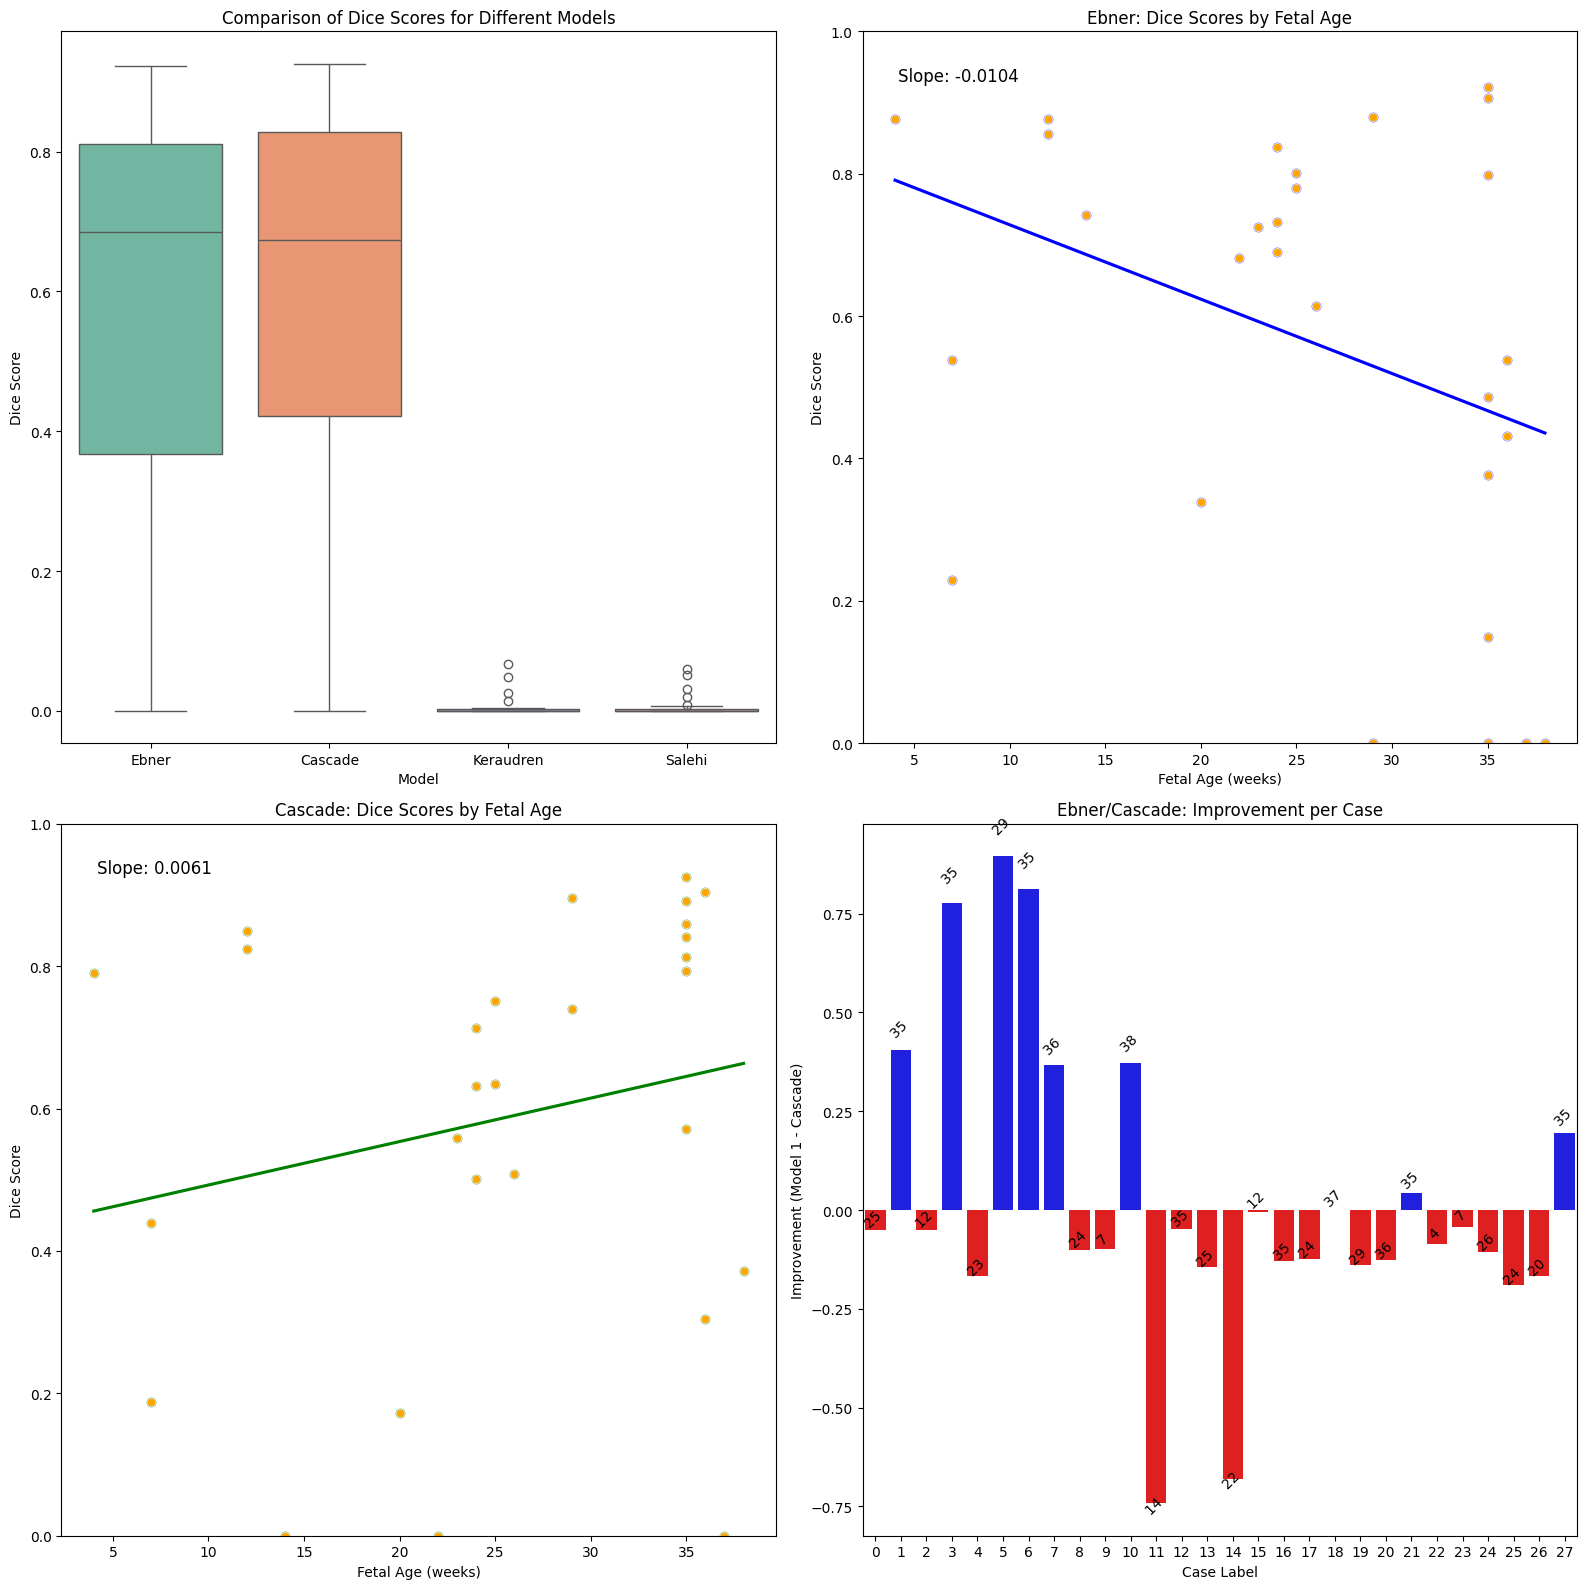

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.linear_model import LinearRegression

# Assuming `fetal_ages` is a list or array of fetal ages corresponding to each case
fetal_ages = np.array(list_of_ages_corresponding_to_cases)  # replace with actual ages
extent_ratio_th = 2

# Compute and report average identification rates
avg_identification_rates = {
    'Ebner': np.mean(identification_rates['Ebner']),
    'Cascade': np.mean(identification_rates['Cascade'])
}
if include_keraudren:
    avg_identification_rates['Keraudren'] = np.mean(identification_rates['Keraudren'])
if include_salehi:
    avg_identification_rates['Salehi'] = np.mean(identification_rates['Salehi'])

# Combine all Dice scores in a dictionary
all_scores = {
    'Ebner': b_ebner_dice_scores_list,
    'Cascade': b_cascade_dice_scores_list
}
if include_keraudren:
    all_scores['Keraudren'] = b_keraudren_dice_scores_list
if include_salehi:
    all_scores['Salehi'] = b_salehi_dice_scores_list

# Convert the dictionary to a DataFrame for easier plotting with seaborn
scores_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in all_scores.items()]))

# Melt the DataFrame to long-form for seaborn
scores_df = scores_df.melt(var_name='Model', value_name='Dice Score')

# Calculate the improvement (Cascade - Ebner) for each case
improvements = np.array(b_cascade_dice_scores_list) - np.array(b_ebner_dice_scores_list)

# Create a DataFrame for the improvements with case labels and fetal ages
cases_df = pd.DataFrame({
    'Case Label': np.arange(len(improvements)),
    'Improvement': improvements,
    'Fetal Age': fetal_ages
})

# Create a new figure with four subplots in a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(16, 16))  # 2 rows and 2 columns

# Function to calculate and annotate slope
def annotate_slope(x, y, ax):
    model = LinearRegression().fit(x.reshape(-1, 1), y)
    slope = model.coef_[0]
    ax.text(0.05, 0.95, f'Slope: {slope:.4f}', transform=ax.transAxes, fontsize=12, verticalalignment='top', color='black')

# Top-left subplot: Box plot for Dice scores
sns.boxplot(x='Model', y='Dice Score', data=scores_df, palette="Set2", ax=axes[0, 0])
axes[0, 0].set_title('Comparison of Dice Scores for Different Models')
axes[0, 0].set_ylabel('Dice Score')
axes[0, 0].set_xlabel('Model')

# Top-right subplot: Scatter plot for Ebner Dice scores with regression line and slope
dice_scores_df = pd.DataFrame(dice_scores)
ebner_scores_df = dice_scores_df[dice_scores_df['model'] == 'Ebner']
ages_ebner = ebner_scores_df['age'].values
dice_scores_ebner = ebner_scores_df['dice'].values
sns.regplot(x=ages_ebner, y=dice_scores_ebner, ax=axes[0, 1], scatter=True, fit_reg=True, ci=None, color='blue')
sns.scatterplot(x=ages_ebner, y=dice_scores_ebner, ax=axes[0, 1], color='orange')
axes[0, 1].set_title('Ebner: Dice Scores by Fetal Age')
axes[0, 1].set_ylabel('Dice Score')
axes[0, 1].set_xlabel('Fetal Age (weeks)')
axes[0, 1].set_ylim(0, 1)
annotate_slope(ages_ebner, dice_scores_ebner, axes[0, 1])

# Bottom-left subplot: Scatter plot for Cascade Dice scores with regression line and slope
cascade_scores_df = dice_scores_df[dice_scores_df['model'] == 'Cascade']
ages_cascade = cascade_scores_df['age'].values
dice_scores_cascade = cascade_scores_df['dice'].values
sns.regplot(x=ages_cascade, y=dice_scores_cascade, ax=axes[1, 0], scatter=True, fit_reg=True, ci=None, color='green')
sns.scatterplot(x=ages_cascade, y=dice_scores_cascade, ax=axes[1, 0], color='orange')
axes[1, 0].set_title('Cascade: Dice Scores by Fetal Age')
axes[1, 0].set_ylabel('Dice Score')
axes[1, 0].set_xlabel('Fetal Age (weeks)')
axes[1, 0].set_ylim(0, 1)
annotate_slope(ages_cascade, dice_scores_cascade, axes[1, 0])

# Bottom-right subplot: Bar plot of improvements (Cascade - Ebner) with fetal ages on top and conditional color
palette = ['blue' if val > 0 else 'red' for val in cases_df['Improvement']]
sns.barplot(x='Case Label', y='Improvement', data=cases_df, ax=axes[1, 1], palette=palette)
axes[1, 1].set_title('Ebner/Cascade: Improvement per Case')
axes[1, 1].set_ylabel('Improvement (Model 1 - Cascade)')
axes[1, 1].set_xlabel('Case Label')

# Add labels on the bars in the bottom-right plot with fetal ages
for p, age in zip(axes[1, 1].patches, cases_df['Fetal Age']):
    height = p.get_height()
    axes[1, 1].annotate(f'{age} ', 
                        (p.get_x() + p.get_width() / 2., 1.05*height), 
                        ha='center', va='center', fontsize=10, color='black', xytext=(0, 10), 
                        textcoords='offset points', rotation=45)

# Adjust layout to prevent overlap
plt.tight_layout()

# Perform the paired Wilcoxon test on filtered data (if applicable)
t_statistic, p_value = stats.wilcoxon(b_ebner_dice_scores_list, b_cascade_dice_scores_list)

# Print test results
print(f"Paired Wilcoxon test between Ebner and Cascade:")
print(f"t-statistic: {t_statistic:.4f}")
print(f"p-value: {p_value:.4f}")

# Interpretation of the result
alpha = 0.05
if p_value < alpha:
    print("The difference in Dice scores between Ebner and Cascade is statistically significant.")
else:
    print("The difference in Dice scores between Ebner and Cascade is not statistically significant.")

# Display the plots
plt.show()


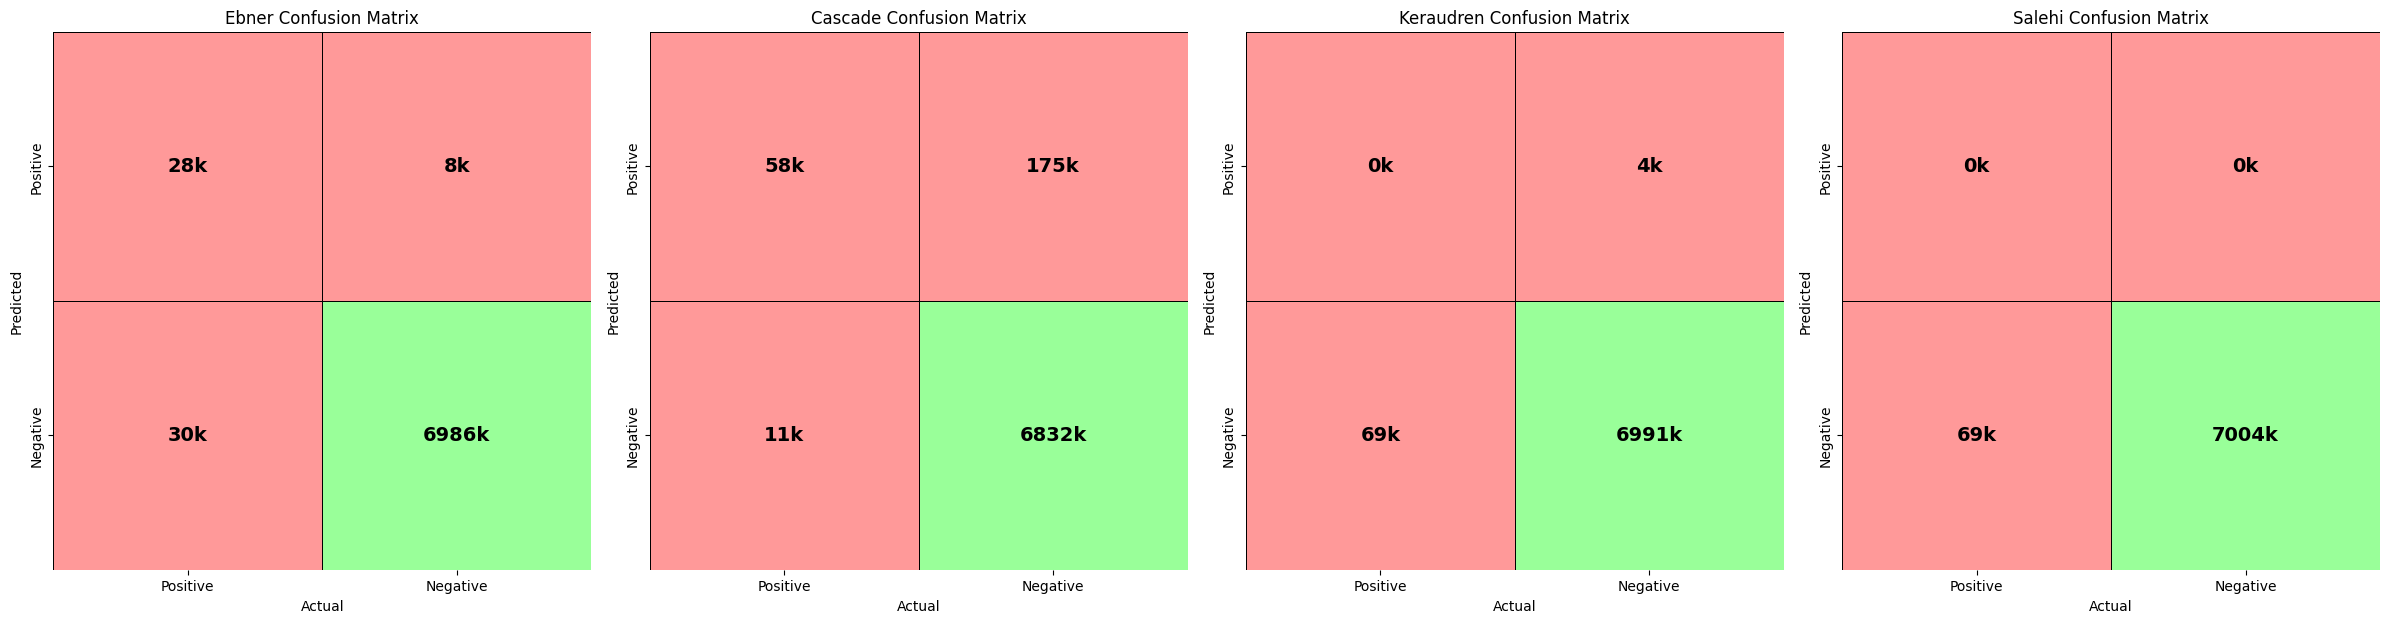

In [3]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Calculate the average confusion matrices
avg_cm_ebner = np.mean(conf_matrices['Ebner'], axis=0)
avg_cm_cascade = np.mean(conf_matrices['Cascade'], axis=0)

# Initialize confusion matrices for additional models
avg_cm_keraudren = np.mean(conf_matrices['Keraudren'], axis=0) if 'Keraudren' in conf_matrices else np.zeros_like(avg_cm_ebner)
avg_cm_salehi = np.mean(conf_matrices['Salehi'], axis=0) if 'Salehi' in conf_matrices else np.zeros_like(avg_cm_ebner)

# Custom colors for the confusion matrix blocks
colors = ['#FF9999', '#FFCC99', '#99CCFF', '#99FF99']
cmap = ListedColormap(colors)

# Create the figure and axes
fig, axes = plt.subplots(1, 4, figsize=(24, 6))

# Plot Ebner Confusion Matrix
sns.heatmap(avg_cm_ebner, annot=False, cmap=cmap, cbar=False,
            linewidths=.5, linecolor='black', square=True, ax=axes[0])

# Custom annotation for large numbers in "k" format
for i in range(avg_cm_ebner.shape[0]):
    for j in range(avg_cm_ebner.shape[1]):
        value = int(avg_cm_ebner[i, j])
        axes[0].text(j + 0.5, i + 0.5, f"{value // 1000}k",
                     ha="center", va="center", color="black", fontsize=14, weight="bold")

axes[0].set_title('Ebner Confusion Matrix')
axes[0].set_xlabel("Actual")
axes[0].set_ylabel("Predicted")
axes[0].set_xticks([0.5, 1.5])
axes[0].set_xticklabels(["Positive", "Negative"])
axes[0].set_yticks([0.5, 1.5])
axes[0].set_yticklabels(["Positive", "Negative"])

# Plot Cascade Confusion Matrix
sns.heatmap(avg_cm_cascade, annot=False, cmap=cmap, cbar=False,
            linewidths=.5, linecolor='black', square=True, ax=axes[1])

# Custom annotation for large numbers in "k" format
for i in range(avg_cm_cascade.shape[0]):
    for j in range(avg_cm_cascade.shape[1]):
        value = int(avg_cm_cascade[i, j])
        axes[1].text(j + 0.5, i + 0.5, f"{value // 1000}k",
                     ha="center", va="center", color="black", fontsize=14, weight="bold")

axes[1].set_title('Cascade Confusion Matrix')
axes[1].set_xlabel("Actual")
axes[1].set_ylabel("Predicted")
axes[1].set_xticks([0.5, 1.5])
axes[1].set_xticklabels(["Positive", "Negative"])
axes[1].set_yticks([0.5, 1.5])
axes[1].set_yticklabels(["Positive", "Negative"])

# Plot Keraudren Confusion Matrix (if available)
if 'Keraudren' in conf_matrices:
    sns.heatmap(avg_cm_keraudren, annot=False, cmap=cmap, cbar=False,
                linewidths=.5, linecolor='black', square=True, ax=axes[2])
    
    # Custom annotation for large numbers in "k" format
    for i in range(avg_cm_keraudren.shape[0]):
        for j in range(avg_cm_keraudren.shape[1]):
            value = int(avg_cm_keraudren[i, j])
            axes[2].text(j + 0.5, i + 0.5, f"{value // 1000}k",
                         ha="center", va="center", color="black", fontsize=14, weight="bold")
    
    axes[2].set_title('Keraudren Confusion Matrix')
    axes[2].set_xlabel("Actual")
    axes[2].set_ylabel("Predicted")
    axes[2].set_xticks([0.5, 1.5])
    axes[2].set_xticklabels(["Positive", "Negative"])
    axes[2].set_yticks([0.5, 1.5])
    axes[2].set_yticklabels(["Positive", "Negative"])

# Plot Salehi Confusion Matrix (if available)
if 'Salehi' in conf_matrices:
    sns.heatmap(avg_cm_salehi, annot=False, cmap=cmap, cbar=False,
                linewidths=.5, linecolor='black', square=True, ax=axes[3])
    
    # Custom annotation for large numbers in "k" format
    for i in range(avg_cm_salehi.shape[0]):
        for j in range(avg_cm_salehi.shape[1]):
            value = int(avg_cm_salehi[i, j])
            axes[3].text(j + 0.5, i + 0.5, f"{value // 1000}k",
                         ha="center", va="center", color="black", fontsize=14, weight="bold")
    
    axes[3].set_title('Salehi Confusion Matrix')
    axes[3].set_xlabel("Actual")
    axes[3].set_ylabel("Predicted")
    axes[3].set_xticks([0.5, 1.5])
    axes[3].set_xticklabels(["Positive", "Negative"])
    axes[3].set_yticks([0.5, 1.5])
    axes[3].set_yticklabels(["Positive", "Negative"])

# Adjust layout to ensure plots don't overlap
plt.tight_layout()

# Show the combined plot
plt.show()


# Cascade Brain Identification

# Level 1 : 48 Unet

# Level 2 : 24 Unet

# Level 3: 12 Unet

# Level 4: 6 Unet